In [1]:
#export
from exp.nb_06 import *

In [2]:
x_train,y_train,x_valid,y_valid = get_data()

train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [3]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [4]:
nfs = [8,16,32,64,64]

In [5]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [6]:
%time run.fit(2, learn)

train: [1.0469061848958334, tensor(0.6673, device='cuda:0')]
valid: [0.18533609619140626, tensor(0.9436, device='cuda:0')]
train: [0.15549513346354166, tensor(0.9523, device='cuda:0')]
valid: [0.1103864990234375, tensor(0.9641, device='cuda:0')]
CPU times: user 6.72 s, sys: 1.41 s, total: 8.13 s
Wall time: 8.11 s


## Batchnorm

In [17]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [12]:
x = torch.randn(128,10,28,28)

In [15]:
x.mean((0,1,2,3),keepdim=True)

tensor([[[[0.0007]]]])

In [16]:
x.mean()

tensor(0.0007)

In [20]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [21]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [22]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

In [23]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

train: [0.254214453125, tensor(0.9218, device='cuda:0')]
valid: [0.43441025390625, tensor(0.8602, device='cuda:0')]


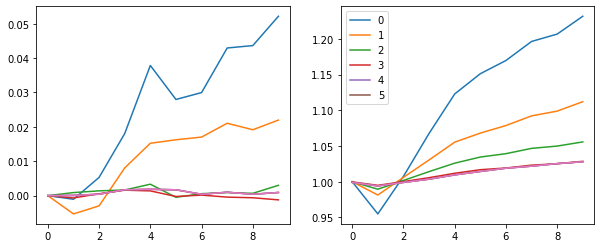

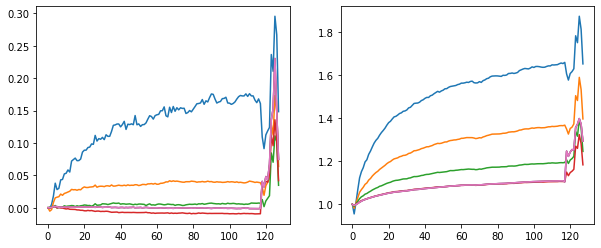

In [24]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [25]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [26]:
%time run.fit(3, learn)

train: [0.2395791015625, tensor(0.9242, device='cuda:0')]
valid: [0.1888239990234375, tensor(0.9427, device='cuda:0')]
train: [0.07840967610677084, tensor(0.9766, device='cuda:0')]
valid: [1.615076953125, tensor(0.7391, device='cuda:0')]
train: [0.05993067220052083, tensor(0.9805, device='cuda:0')]
valid: [0.09948278198242187, tensor(0.9668, device='cuda:0')]
CPU times: user 7.28 s, sys: 78.2 ms, total: 7.36 s
Wall time: 7.3 s


In [27]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [28]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [29]:
%time run.fit(3, learn)

train: [0.19813444010416667, tensor(0.9383, device='cuda:0')]
valid: [0.206664013671875, tensor(0.9330, device='cuda:0')]
train: [0.060713509114583335, tensor(0.9813, device='cuda:0')]
valid: [0.17020653076171874, tensor(0.9410, device='cuda:0')]
train: [0.04411284993489583, tensor(0.9862, device='cuda:0')]
valid: [0.08159256591796875, tensor(0.9713, device='cuda:0')]
CPU times: user 7.1 s, sys: 57.8 ms, total: 7.15 s
Wall time: 7.1 s


In [30]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [31]:
run.fit(8, learn)

/home/feynmen-data-science/fastai2019_ii/exp/nb_06.py:138: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx = (pos >= pcts).nonzero().max()


train: [0.221611279296875, tensor(0.9332, device='cuda:0')]
valid: [0.1627821533203125, tensor(0.9495, device='cuda:0')]
train: [0.0734353759765625, tensor(0.9767, device='cuda:0')]
valid: [1.1900193359375, tensor(0.8527, device='cuda:0')]
train: [0.07759991861979167, tensor(0.9769, device='cuda:0')]
valid: [0.08410714111328126, tensor(0.9731, device='cuda:0')]
train: [0.031455548095703126, tensor(0.9902, device='cuda:0')]
valid: [0.05022736511230469, tensor(0.9830, device='cuda:0')]
train: [0.019780196126302083, tensor(0.9941, device='cuda:0')]
valid: [0.04087331848144531, tensor(0.9872, device='cuda:0')]
train: [0.01230558573404948, tensor(0.9964, device='cuda:0')]
valid: [0.033686236572265625, tensor(0.9883, device='cuda:0')]
train: [0.007716472880045573, tensor(0.9983, device='cuda:0')]
valid: [0.03497106323242188, tensor(0.9884, device='cuda:0')]
train: [0.0056584716796875, tensor(0.9991, device='cuda:0')]
valid: [0.0339574462890625, tensor(0.9884, device='cuda:0')]


## LayerNorm 

In [43]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(torch.ones(1))
        self.add  = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [44]:
x = torch.randn(128,32,28,28)
x.mean((1,2,3),keepdim=True).shape

torch.Size([128, 1, 1, 1])

In [45]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [46]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [47]:
%time run.fit(3, learn)

train: [nan, tensor(0.1201, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
CPU times: user 8.87 s, sys: 57 ms, total: 8.93 s
Wall time: 8.87 s


## InstanceNorm 

In [48]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [49]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [50]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [51]:
%time run.fit(3, learn)

train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0980, device='cuda:0')]
CPU times: user 8.84 s, sys: 118 ms, total: 8.96 s
Wall time: 8.91 s


## Fix small batches 

In [52]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [53]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [54]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [55]:
%time run.fit(1, learn)

train: [2.351509114583333, tensor(0.1520, device='cuda:0')]
valid: [282173.7728, tensor(0.1837, device='cuda:0')]
CPU times: user 2min 26s, sys: 1.2 s, total: 2min 27s
Wall time: 2min 27s


## Running Batch Norm 

In [56]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [57]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [59]:
%time run.fit(3, learn)

train: [2.3321815104166665, tensor(0.1745, device='cuda:0')]
valid: [12730.1168, tensor(0.2116, device='cuda:0')]
train: [2.29255859375, tensor(0.1952, device='cuda:0')]
valid: [31995772.928, tensor(0.2543, device='cuda:0')]
train: [2.2754497395833333, tensor(0.1999, device='cuda:0')]
valid: [49928870.2976, tensor(0.2203, device='cuda:0')]
CPU times: user 7min 21s, sys: 5.07 s, total: 7min 26s
Wall time: 7min 25s


In [2]:
!python notebook2script.py 07_batchnorm.ipynb

Converted 07_batchnorm.ipynb to exp/nb_07.py
